In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from walidacja_funkcji import *

prober = rs_prober_NKG(epsilon=0.1, looking_x_left=-1, looking_x_right=1, from_x=0)

def get_2d_data(PROBE_SIZE: int):
    rs = prober.rejection_sampling(length=PROBE_SIZE // 2)
    theta = np.random.uniform(0, 2*np.pi, size=PROBE_SIZE // 2)
    xs = rs * np.cos(theta)
    ys = rs * np.sin(theta)
    return np.vstack([xs, ys]).T

In [143]:
class NF_layer(nn.Module):
    def __init__(self, translate_layers: list[nn.Module], scale_layers: list[nn.Module], lr):
        super().__init__()
        self.translate = nn.Sequential(*translate_layers)
        self.scale = nn.Sequential(*scale_layers)
        self.optim = torch.optim.SGD(self.parameters(), lr=lr) # tu nie jestem pewny moze dwa oddzielne optimizery powinny isc idk

        for layer in self.scale:
            if hasattr(layer, 'weight'):
                nn.init.constant_(layer.weight, 1e-3)

        self.to('cuda')

    # mozna dodac loss_backward z funkcja probkowania z NKG
    def loss(self, output: torch.Tensor, log_diag: torch.Tensor = None, input: torch.Tensor = None): 
        """ input - tensor of shape (batch, N) """
        if log_diag is None or output is None:
            output, log_diag = self.forward(input)

        return 0.5 * (output ** 2).mean() - log_diag # srednia po batchu generalnie

    def loss_and_step(self, output: torch.Tensor, log_diag: torch.Tensor = None, input: torch.Tensor = None):
        self.zero_grad()
        loss = self.loss(output, log_diag, input)
        loss.backward()
        self.optim.step()
        return loss.item()

    def calculate_forward(self, input: torch.Tensor, function: callable) -> torch.Tensor:
        div_indx = input.shape[-1] // 2
        x1 = input[:, :div_indx]
        x2 = input[:, div_indx:]
        
        scaled = self.scale(x1)
        translated = self.translate(x1)
        diag_sum = scaled.mean() # we wzorze jest dzielenie przez N, czyli srednia troche nawet zawyza wynik, ale to chyba dobrze
        x1 = function(x2, scaled, translated)
        z = torch.cat([x2, x1], dim=-1) # swap
        
        return z, diag_sum

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return self.calculate_forward(input, lambda x2, scaled, translated: x2 * torch.exp(scaled) + translated)

    def inverse(self, input: torch.Tensor) -> torch.Tensor:
        return self.calculate_forward(input, lambda x2, scaled, translated: (x2 - translated) / torch.exp(scaled))


class NF(nn.Module):
    def __init__(self, num_layers: int, input_size: int, lr: float):
        super().__init__()
        components = [
            nn.Linear(input_size, input_size), nn.ReLU(), nn.BatchNorm1d(input_size),
            nn.Linear(input_size, input_size), nn.BatchNorm1d(input_size),
            nn.Linear(input_size, input_size), nn.BatchNorm1d(input_size),
            nn.Linear(input_size, input_size),
        ]

        self.layers = [NF_layer(components, components, lr) for _ in range(num_layers)]
        self.to('cuda')
        
    def forward(self, x):
        return self.iterate_layers(x, forward=True, learn=False)
    
    def inverse(self, x):
        return self.iterate_layers(x, forward=False, learn=False)
    
    def loss_and_step(self, x):
        return self.iterate_layers(x, forward=True, learn=True)
    
    def iterate_layers(self, input: torch.Tensor, forward: bool, learn: bool):
        output = input.clone()
        losses = []
        
        iter_layers = self.layers if forward else reversed(self.layers)
        for layer in iter_layers:
            output, diag_sum = layer.forward(output)
            if learn:
                loss = layer.loss(output, diag_sum)
                losses.append(loss)
        
        if learn:
            total_loss = sum(losses)
            total_loss.backward()
            for layer in self.layers:
                layer.optim.step()
                layer.optim.zero_grad()

            return total_loss
        
        return output

"""
    Czy NF oddzielnie powinien przelozyc x i y ??
    Dla kazdego wymiaru bedzie to oddzielnie szlo chyba zreszta musi isc oddzielnie
"""

'\n    Czy NF oddzielnie powinien przelozyc x i y ??\n    Dla kazdego wymiaru bedzie to oddzielnie szlo chyba zreszta musi isc oddzielnie\n'

In [144]:
BATCH_SIZE = 8
PROBES_PER_BATCH = 320
PROBE_SIZE = BATCH_SIZE * PROBES_PER_BATCH
DIMS = PROBES_PER_BATCH // 4
EPOCHS = 1000

values = get_2d_data(PROBE_SIZE=PROBE_SIZE).reshape(BATCH_SIZE, -1, 2)
x, y = torch.Tensor(values[:, :, 0]).cuda(), torch.Tensor(values[:, :, 1]).cuda()

loss_history = np.empty(EPOCHS)
nf_model = NF(7, DIMS, 1e-3)

for epoch in range(EPOCHS):
    print(f'\r{epoch / (EPOCHS - 1) * 100 :.1f}%', end='', flush=True)
    loss_history[epoch] = nf_model.loss_and_step(x) # lossa nie daje

0.0%

100.0%

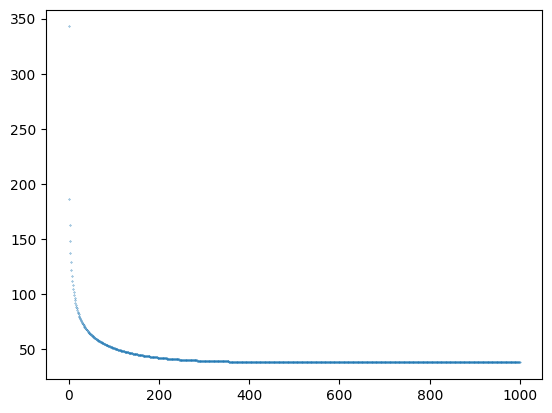

In [145]:
plt.plot(loss_history, 'o', markersize=0.3)
plt.show()

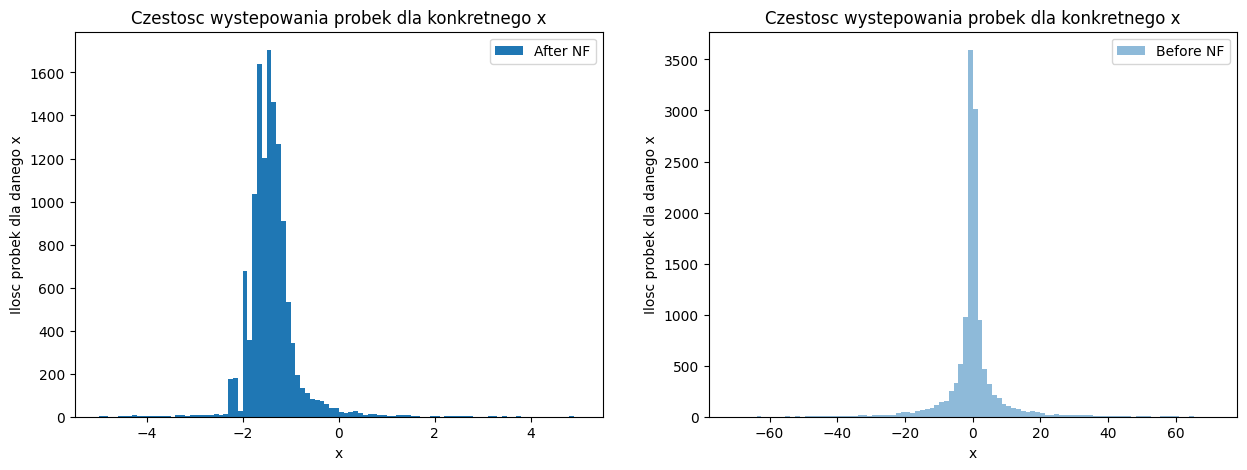

In [148]:
temp = get_2d_data(PROBE_SIZE=PROBE_SIZE * 10).reshape(BATCH_SIZE * 10, -1, 2)
x, y = torch.Tensor(temp[:, :, 0]).cuda(), torch.Tensor(temp[:, :, 1]).cuda()

values = nf_model.forward(x)
values = values.detach().flatten().cpu().numpy()
# ewidentnie ten sam blad - polowa jest nanami dokladnie to jest to ta polowa przkesztalcana

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ax1.set_title('Czestosc wystepowania probek dla konkretnego x')
_ = ax1.hist(values, bins=100, range=[-5, 5], label='After NF')
ax1.set_xlabel('x')
ax1.set_ylabel('Ilosc probek dla danego x')
ax1.legend()

ax2.set_title('Czestosc wystepowania probek dla konkretnego x')
_ = ax2.hist(x.detach().flatten().cpu().numpy(), bins=100, alpha=0.5, label='Before NF')
ax2.set_xlabel('x')
ax2.set_ylabel('Ilosc probek dla danego x')
ax2.legend()

In [127]:
np.isnan(values).sum()

np.int64(0)